In [1]:
#pip install opencv-python matplotlib


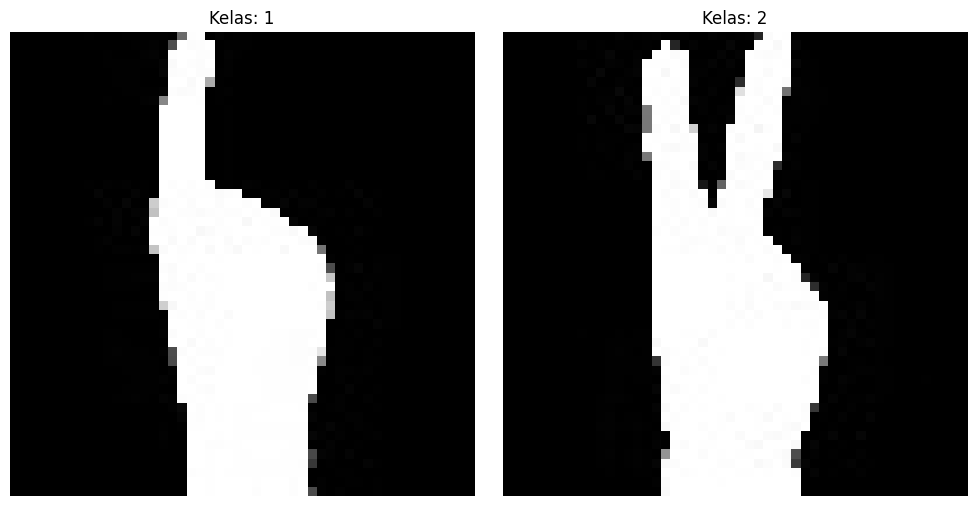

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Path dasar ke folder dataset
base_path = "D:/Semester 6/Komputer Vision/Project/visual-command/test"
folders = ["1", "2"]

# Buat figure untuk menampilkan gambar
plt.figure(figsize=(10, 5))

for i, selected_class in enumerate(folders):
    folder_path = os.path.join(base_path, selected_class)
    
    # Ambil semua nama file gambar di folder tersebut
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if image_files:
        # Ambil gambar pertama (atau bisa juga pilih secara acak)
        selected_image = image_files[0]
        image_path = os.path.join(folder_path, selected_image)
        
        # Baca dan konversi gambar
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Tampilkan di subplot
        plt.subplot(1, 2, i+1)
        plt.imshow(image_rgb)
        plt.title(f"Kelas: {selected_class}")
        plt.axis('off')
    else:
        print(f"Tidak ada gambar ditemukan di folder {folder_path}")

plt.tight_layout()
plt.show()


In [3]:
import cv2
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# Path dasar ke folder dataset
base_path = "D:/Semester 6/Komputer Vision/Project/visual-command/test"
folders = ["1", "2"]

# Label mapping
label_map = {
    "1": 0,
    "2": 1
}

# Fungsi ekstraksi gabungan fitur piksel dan bentuk
def extract_combined_features(binary_img):
    # --- Fitur piksel ---
    edges = cv2.Canny(binary_img, 100, 200)
    total_edge_pixels = np.sum(edges > 0)

    white_pixel_count = np.sum(binary_img == 255)
    height = binary_img.shape[0]
    upper_half = binary_img[:height // 2, :]
    white_pixel_upper = np.sum(upper_half == 255)
    white_pixel_upper_ratio = white_pixel_upper / white_pixel_count if white_pixel_count > 0 else 0

    column_sum = np.sum(binary_img == 255, axis=0)
    peaks, _ = find_peaks(column_sum, distance=10, prominence=10)
    white_column_peaks = len(peaks)

    # --- Fitur bentuk ---
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        hull = cv2.convexHull(cnt, returnPoints=False)
        if hull is not None and len(hull) > 3:
            defects = cv2.convexityDefects(cnt, hull)
            num_defects = 0 if defects is None else defects.shape[0]
        else:
            num_defects = 0

        x, y, w, h = cv2.boundingRect(cnt)
        rect_area = w * h
        extent = float(cv2.contourArea(cnt)) / rect_area if rect_area > 0 else 0

        moments = cv2.moments(binary_img)
        hu_moments = cv2.HuMoments(moments).flatten()
        hu_moment_1 = -np.sign(hu_moments[0]) * np.log10(abs(hu_moments[0])) if hu_moments[0] != 0 else 0
    else:
        num_defects = 0
        extent = 0
        hu_moment_1 = 0

    return [
        total_edge_pixels,
        white_pixel_count,
        white_pixel_upper_ratio,
        white_column_peaks,
        num_defects,
        extent,
        hu_moment_1
    ]

# Proses ekstraksi fitur
data = []

for folder in folders:
    label_num = label_map[folder]
    folder_path = os.path.join(base_path, folder)

    if not os.path.exists(folder_path):
        print(f"Folder tidak ditemukan: {folder_path}")
        continue

    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for file in files:
        img_path = os.path.join(folder_path, file)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Gagal membaca gambar: {img_path}")
            continue

        # Konversi ke grayscale dan biner
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

        # Ekstraksi fitur
        features = extract_combined_features(binary_img)
        data.append([file, label_num] + features)

# Simpan ke CSV
columns = [
    "filename", "label",
    "total_edge_pixels", "white_pixel_count", "white_pixel_upper_ratio", "white_column_peaks",
    "num_defects", "extent", "hu_moment_1"
]
df = pd.DataFrame(data, columns=columns)

csv_output_path = "fitur_tangan_gabungan.csv"
df.to_csv(csv_output_path, index=False)
print(f"Fitur gabungan berhasil disimpan ke: {csv_output_path}")


Fitur gabungan berhasil disimpan ke: fitur_tangan_gabungan.csv


In [4]:
#pip install scikit-learn

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Baca CSV hasil ekstraksi fitur
df = pd.read_csv("fitur_tangan_gabungan.csv")

# Pisahkan kolom non-fitur (filename & label)
non_feature_cols = ['filename', 'label']
feature_cols = [col for col in df.columns if col not in non_feature_cols]

# Lakukan normalisasi dengan MinMaxScaler
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# Simpan ke file CSV baru
df_scaled.to_csv("fitur_tangan_normalized.csv", index=False)
print("Normalisasi selesai. Disimpan sebagai: fitur_tangan_normalized.csv")


Normalisasi selesai. Disimpan sebagai: fitur_tangan_normalized.csv


In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

X = df.drop(columns=["filename", "label"])
y = df["label"]

selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X, y)

# Menampilkan fitur yang dipilih
selected_features = X.columns[selector.get_support()]
print("Fitur yang dipilih:", list(selected_features))


Fitur yang dipilih: ['total_edge_pixels', 'white_pixel_count', 'white_pixel_upper_ratio', 'extent', 'hu_moment_1']


In [7]:
#pip install seaborn

C:\Users\user\AppData\Local\Temp\ipykernel_19680\1989654809.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_limited = df_scaled.groupby('label', group_keys=False).apply(lambda x: x.sample(n=100, random_state=42) if len(x) > 100 else x)


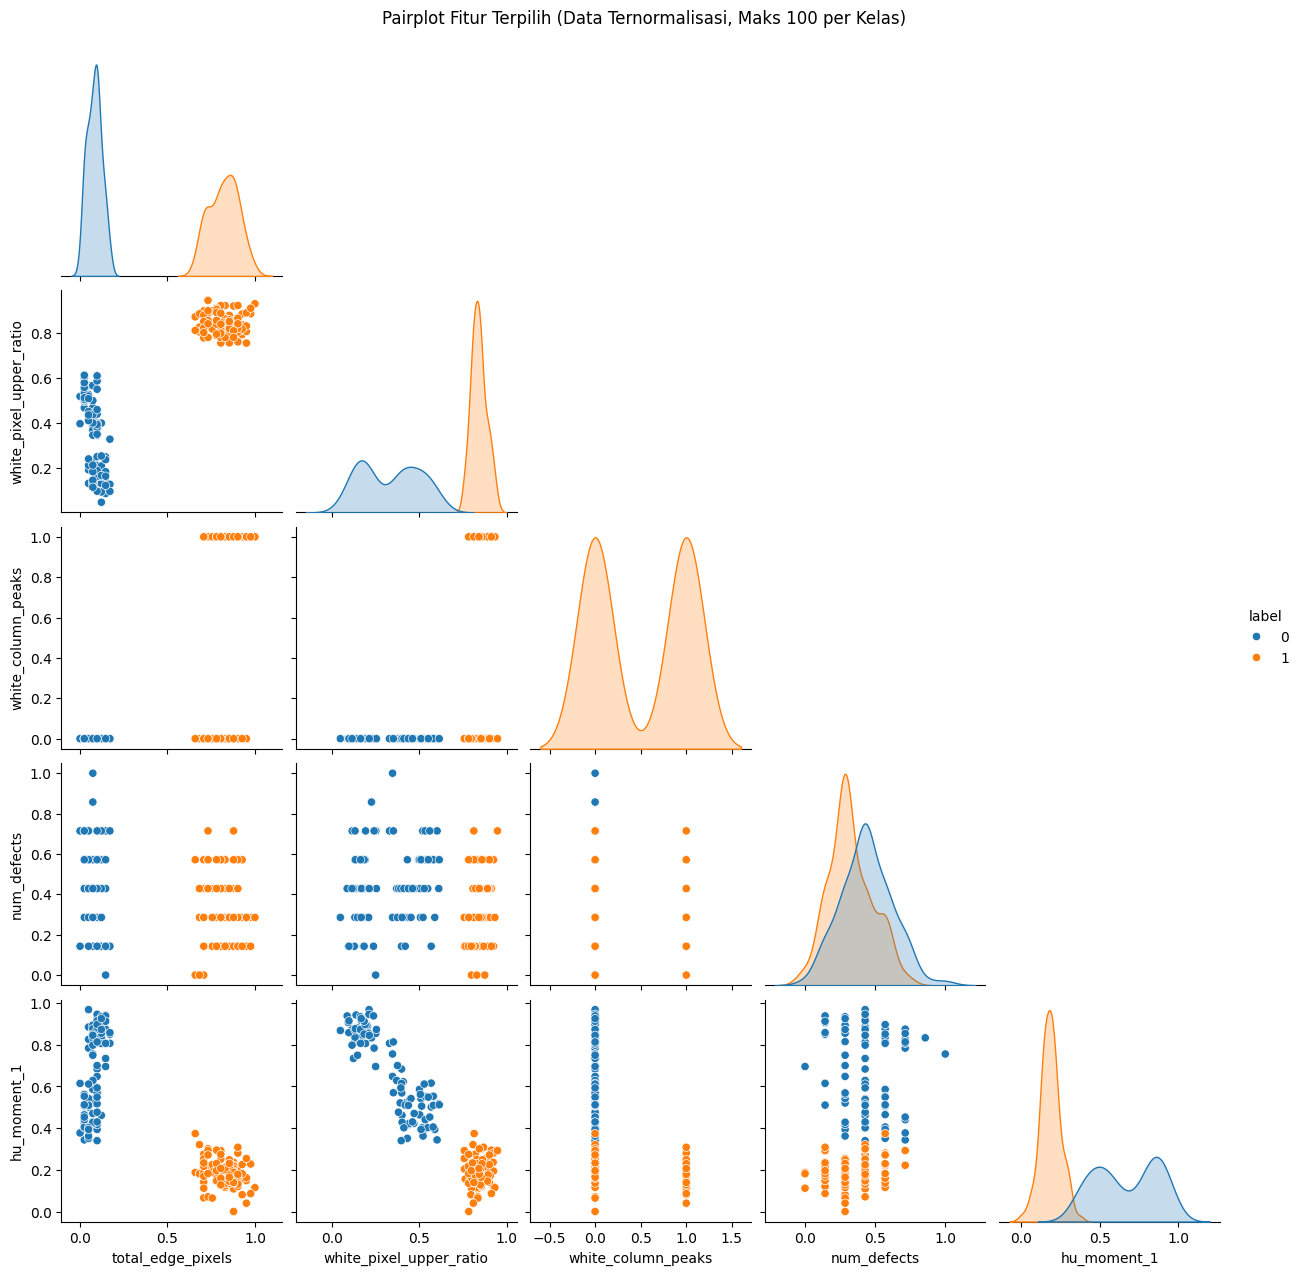

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan label masih ada di df_scaled
df_scaled['label'] = df['label']  # Ambil label dari dataframe asli (sebelum scaling)

# Batasi jumlah data menjadi 100 per kelas
df_limited = df_scaled.groupby('label', group_keys=False).apply(lambda x: x.sample(n=100, random_state=42) if len(x) > 100 else x)

# Pilih fitur-fitur yang telah diseleksi
selected_features = ['total_edge_pixels', 'white_pixel_upper_ratio', 'white_column_peaks', 'num_defects', 'hu_moment_1']

# Buat pairplot
sns.pairplot(df_limited[selected_features + ['label']], hue='label', diag_kind='kde', corner=True)
plt.suptitle("Pairplot Fitur Terpilih (Data Ternormalisasi, Maks 100 per Kelas)", y=1.02)
plt.show()


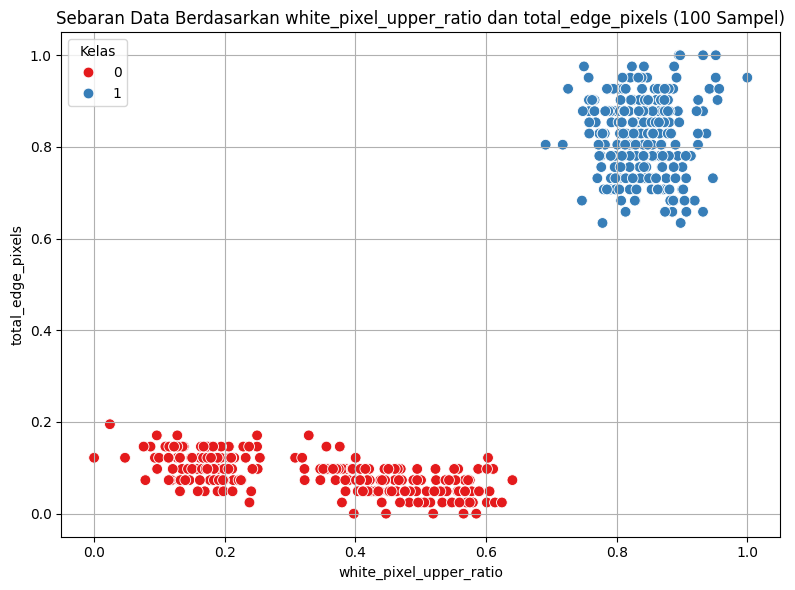

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sinkronkan label jika belum ada
df_scaled['label'] = df['label']

# Ambil 100 data secara acak dari keseluruhan dataset
df_sampled = df_scaled.sample(n=500, random_state=42)

# Pilih dua fitur yang akan divisualisasikan
# x_feature = 'total_edge_pixels'
x_feature = 'white_pixel_upper_ratio'
y_feature = 'total_edge_pixels'

# Buat scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sampled, x=x_feature, y=y_feature, hue='label', palette='Set1', s=60)

plt.title(f"Sebaran Data Berdasarkan {x_feature} dan {y_feature} (100 Sampel)")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend(title='Kelas', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


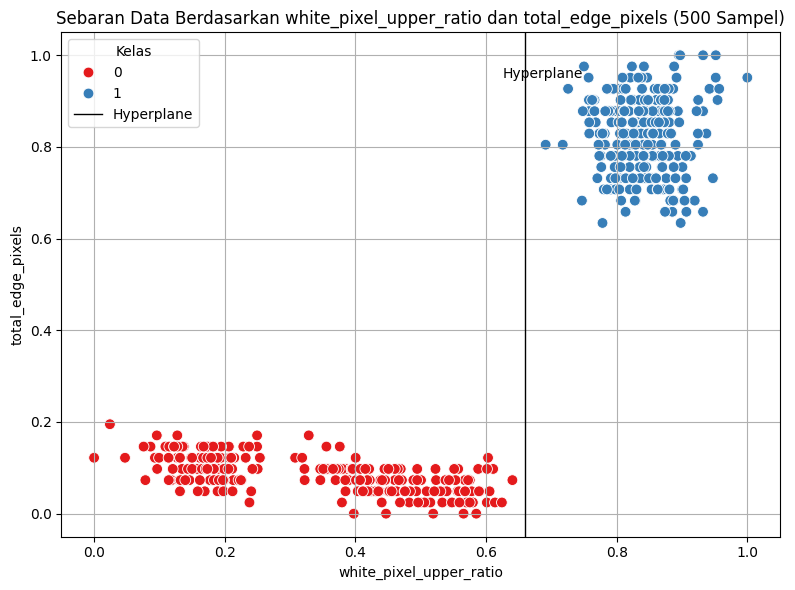

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sinkronkan label jika belum ada
df_scaled["label"] = df["label"]

# Ambil 100 data secara acak dari keseluruhan dataset
df_sampled = df_scaled.sample(n=500, random_state=42)

# Pilih dua fitur yang akan divisualisasikan
x_feature = "white_pixel_upper_ratio"
y_feature = "total_edge_pixels"

# Buat scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sampled, x=x_feature, y=y_feature, hue="label", palette="Set1", s=60
)

# Tambahkan garis vertikal (hyperplane)
plt.axvline(x=0.66, color="black", linestyle="-", linewidth=1, label="Hyperplane")
plt.text(
    0.625,
    df_sampled[y_feature].max() * 0.95,
    "Hyperplane",
    rotation=0,
    color="black",
    fontsize=10,
)

# Label dan layout
plt.title(f"Sebaran Data Berdasarkan {x_feature} dan {y_feature} (500 Sampel)")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend(title="Kelas", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

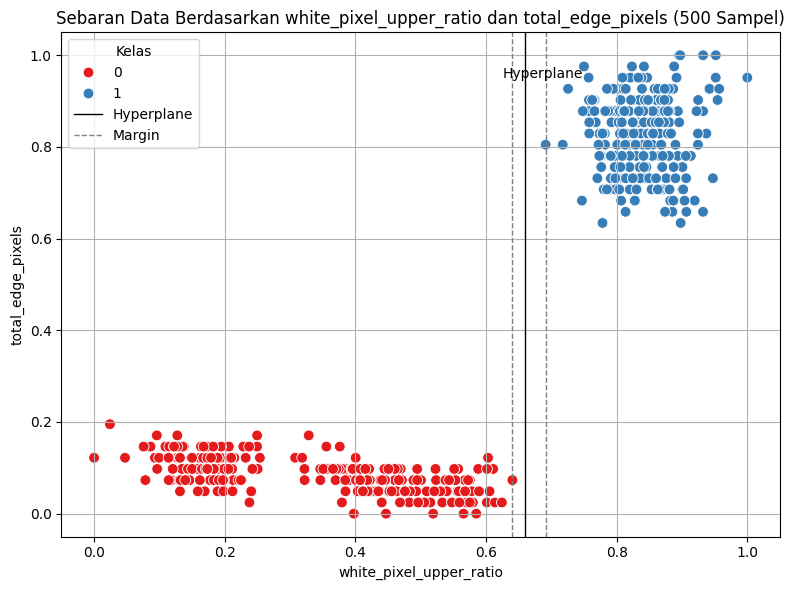

Jarak margin sisi kiri : 0.01963900864477741
Jarak margin sisi kanan: 0.03124172860849772
Margin total :  0.05088073725327513


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sinkronkan label jika belum ada
df_scaled["label"] = df["label"]

# Ambil 100 data secara acak dari keseluruhan dataset
df_sampled = df_scaled.sample(n=500, random_state=42)

# Pilih dua fitur yang akan divisualisasikan
x_feature = "white_pixel_upper_ratio"
y_feature = "total_edge_pixels"

# Buat scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sampled, x=x_feature, y=y_feature, hue="label", palette="Set1", s=60
)

# Tambahkan garis vertikal (hyperplane)
plt.axvline(x=0.66, color="black", linestyle="-", linewidth=1, label="Hyperplane")
plt.text(
    0.625,
    df_sampled[y_feature].max() * 0.95,
    "Hyperplane",
    rotation=0,
    color="black",
    fontsize=10,
)

# Hitung jarak ke hyperplane
df_sampled["dist_to_hyperplane"] = abs(df_sampled[x_feature] - 0.66)

# Pisahkan titik sisi kiri dan kanan
left_points = df_sampled[df_sampled[x_feature] < 0.66]
right_points = df_sampled[df_sampled[x_feature] > 0.66]

# Cari jarak minimum dari masing-masing sisi
min_dist_left = (0.66 - left_points[x_feature]).min()
min_dist_right = (right_points[x_feature] - 0.66).min()

# Tambahkan garis margin kiri dan kanan berdasarkan sisi masing-masing
plt.axvline(
    x=0.66 - min_dist_left, color="gray", linestyle="--", linewidth=1, label="Margin"
)
plt.axvline(x=0.66 + min_dist_right, color="gray", linestyle="--", linewidth=1)

# Tambahkan titik support vector kiri dan kanan
support_vector_left = left_points[left_points[x_feature] == (0.66 - min_dist_left)]
support_vector_right = right_points[right_points[x_feature] == (0.66 + min_dist_right)]

# Gabungkan support vectors
support_vectors = pd.concat([support_vector_left, support_vector_right])

# Label dan layout
plt.title(f"Sebaran Data Berdasarkan {x_feature} dan {y_feature} (500 Sampel)")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend(title="Kelas", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Jarak margin sisi kiri :", min_dist_left)
print("Jarak margin sisi kanan:", min_dist_right)
margin_total = min_dist_left + min_dist_right
print("Margin total : ", margin_total)

In [13]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

n_train = X_train.shape[0]

print("Jumlah total data      :", len(X))
print("Jumlah data latih      :", len(X_train))
print("Jumlah data uji        :", len(X_test))

# Hitung proporsi masing-masing kelas di train dan test
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("\nDistribusi kelas di data latih:")
for cls, count in zip(unique_train, counts_train):
    print(f"  Kelas {cls}: {count} data")

print("\nDistribusi kelas di data uji:")
for cls, count in zip(unique_test, counts_test):
    print(f"  Kelas {cls}: {count} data")



Jumlah total data      : 600
Jumlah data latih      : 420
Jumlah data uji        : 180

Distribusi kelas di data latih:
  Kelas 0: 210 data
  Kelas 1: 210 data

Distribusi kelas di data uji:
  Kelas 0: 90 data
  Kelas 1: 90 data
